# Fasttext tweet classification

## Data file creation

In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import random
import re
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [2]:
DATADIR = "../data/"
TOPIC = "distance"
FILETWEETS = TOPIC+"-tweets.csv"
FILEANNOTATIONS = FILETWEETS+".human-labels.txt"
FILEFASTTEXT = "fasttext-"+TOPIC+".csv"
LABELPREFIX = "__label__"
LARGEINT = 9999999999
LABEL = "label"
TEXT = "text"
USER = "user"
IDSTR = "id_str"
ANNOTATOR = "erikt@xs4all.nl"

In [3]:
tweets = pd.read_csv(DATADIR+FILETWEETS,index_col=IDSTR)
annotations = pd.read_csv(DATADIR+FILEANNOTATIONS,header=None,sep=" ")

In [4]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

In [5]:
fasttextData = {}
for i in range(0,len(annotations)):
    annotator = annotations.iloc[i][0]
    tweetId = annotations.iloc[i][2]
    tweetLabel = annotations.iloc[i][4]
    if annotator == ANNOTATOR and tweetId in list(tweets.index):
        tweetLabel = annotations.iloc[i][4]
        tweetUser = tweets.loc[tweetId][1]
        fasttextData[tweetId] = {LABEL:LABELPREFIX+tweetLabel,\
                                 USER:tweetUser,\
                                 TEXT:" ".join(TweetTokenizer().tokenize(cleanup(tweets.loc[tweetId][TEXT])))}

In [6]:
outFile = open(FILEFASTTEXT,"w")
seenTexts = {}
for tweetId in fasttextData:
    text = cleanup(fasttextData[tweetId][TEXT])
    if not text in seenTexts:
        print(fasttextData[tweetId][LABEL],text,file=outFile)
        seenTexts[text] = True
outFile.close()

In [7]:
nbrOfAnnotationMinutes = len(set([str(x)[:12] for x in annotations[1]]))
nbrOfAnnotatedTweets = len(set([str(x)[:12] for x in annotations[2]]))
print("tweets annotated per minute:",round(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes,1),"; 1000 tweets take:",round(1000/(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes)),"minutes")

tweets annotated per minute: 5.0 ; 1000 tweets take: 200 minutes


## Fasttext run and evaluation

In [8]:
import fasttext
import random
from IPython.display import clear_output

In [9]:
PRETRAINEDDIR = "/home/erikt/projects/newsgac/fasttext-runs/"
WIKIFILENAME = "wiki.nl.vec"

In [10]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [11]:
fasttextData = []
inFile = open(FILEFASTTEXT,"r")
for line in inFile: fasttextData.append(line.strip())
inFile.close()
len(fasttextData)

4501

In [12]:
DIM = 100
EPOCH = 100
LR = 0.05
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))

In [13]:
def ranSelect(inList,size):
    outList = []
    selectionList = list(inList)
    while len(outList) < size and len(selectionList) > 0:
        index = int(random.random()*len(selectionList))
        outList.append(selectionList[index])
        del(selectionList[index])
    return(outList)

In [14]:
def runFasttext(fasttextData,dim=DIM,epoch=EPOCH,lr=LR,n=N,squealFlag=True,maxTrain=None):
    predictionCounts = []
    predictionLabels = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        testStart = round(fold*len(fasttextData)/n)
        testEnd = round((fold+1)*len(fasttextData)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        trainData = []
        testData = []
        for i in range(0,len(fasttextData)):
            data = fasttextData[i]
            if i < testStart or i >= testEnd: 
                print(data,file=trainFile)
                trainData.append(data)
            else: 
                print(data,file=testFile)
                testData.append(data)
        testFile.close()
        trainFile.close()
        if not maxTrain == None and maxTrain < len(trainData):
            trainData = ranSelect(trainData,maxTrain)
            trainFile = open(TRAIN,"w")
            for i in range(0,len(trainData)):
                print(trainData[i],file=trainFile)
            trainFile.close()
        model = fasttext.train_supervised(TRAIN,dim=dim,epoch=epoch,lr=lr)
        predictionCounts.append([*model.test(TEST)])
        predictionLabels.append(model.predict(testData))
        os.unlink(TRAIN)
        os.unlink(TEST)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCounts,predictionLabels)

In [15]:
def makeConfusionMatrix(fasttextData,predictionLabels):
    goldLabels = pd.Series([fasttextData[i].split()[0] for i in range(0,len(fasttextData))])
    predictedLabels = pd.Series([x[0] for row in predictionLabels for x in row[0]])
    return(pd.crosstab(goldLabels,predictedLabels))

In [16]:
def evaluate(predictionCounts,predictionLabels,fasttextData,printResults=True):
    caseTotal = 0
    pTotal = 0
    rTotal = 0
    for i in range(0,len(predictionCounts)):
        caseTotal += predictionCounts[i][0]
        pTotal += predictionCounts[i][0]*predictionCounts[i][1]
        rTotal += predictionCounts[i][0]*predictionCounts[i][2]
    precision = round(pTotal/caseTotal,3)
    recall = round(rTotal/caseTotal,3)
    cf = makeConfusionMatrix(fasttextData,predictionLabels)
    for label in ['__label__REJECTS','__label__REJECTS','__label__IRRELEVANT']:
        if not label in cf: cf[label] = [0 for i in range(0,3)]
    factor = sum(cf.loc['__label__SUPPORTS'])*sum([cf.iloc[i]['__label__REJECTS'] for i in range(0,len(cf))])/\
             (sum(cf.loc['__label__REJECTS'])*sum([cf.iloc[i]['__label__SUPPORTS'] for i in range(0,len(cf))]))
    if printResults: print("cases: {0}; precision: {1}; recall: {2}; factor: {3:0.3f}".format(caseTotal,precision,recall,factor))
    return((precision,factor))

## Grid search

In [17]:
scores = {}
for dim in [10,20,50,100,200,300]:
    for epoch in [10,20,50,100,200,300]:
        for lr in [0.05,0.1,0.2]:
            predictionCounts,predictionLabels = runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
            print(dim,epoch,lr,end=" ")
            key = " ".join([str(dim),str(epoch),str(lr)])
            scores[key] = evaluate(predictionCounts,predictionLabels,fasttextData)

10 10 0.05 cases: 4501; precision: 0.611; recall: 0.611; factor: 0.275
10 10 0.1 cases: 4501; precision: 0.643; recall: 0.643; factor: 0.534
10 10 0.2 cases: 4501; precision: 0.648; recall: 0.648; factor: 0.734
10 20 0.05 cases: 4501; precision: 0.645; recall: 0.645; factor: 0.587
10 20 0.1 cases: 4501; precision: 0.647; recall: 0.647; factor: 0.691
10 20 0.2 cases: 4501; precision: 0.642; recall: 0.642; factor: 0.748
10 50 0.05 cases: 4501; precision: 0.645; recall: 0.645; factor: 0.731
10 50 0.1 cases: 4501; precision: 0.639; recall: 0.639; factor: 0.766
10 50 0.2 cases: 4501; precision: 0.634; recall: 0.634; factor: 0.776
10 100 0.05 cases: 4501; precision: 0.637; recall: 0.637; factor: 0.761
10 100 0.1 cases: 4501; precision: 0.638; recall: 0.638; factor: 0.794
10 100 0.2 cases: 4501; precision: 0.637; recall: 0.637; factor: 0.794
10 200 0.05 cases: 4501; precision: 0.636; recall: 0.636; factor: 0.787
10 200 0.1 cases: 4501; precision: 0.636; recall: 0.636; factor: 0.788
10 200 0.2

In [18]:
[(scores[k],k) for k in sorted(scores.keys(),key=lambda k:scores[k][0],reverse=True)][0:10]

[((0.65, 0.6049783212318292), '20 20 0.05'),
 ((0.649, 0.6968082193986828), '20 10 0.2'),
 ((0.649, 0.588786435345016), '200 10 0.1'),
 ((0.649, 0.6906425364758698), '200 20 0.1'),
 ((0.648, 0.7339147099946965), '10 10 0.2'),
 ((0.648, 0.5840518455903071), '20 10 0.1'),
 ((0.648, 0.7235954827136334), '20 20 0.1'),
 ((0.648, 0.7009807237064593), '100 20 0.1'),
 ((0.647, 0.6913408605774632), '10 20 0.1'),
 ((0.647, 0.5730861544369609), '50 10 0.1')]

In [26]:
[(scores[k],k) for k in sorted(scores.keys(),key=lambda k:scores[k][1],reverse=True)][0:10]

[((0.633, 0.8202823586941859), '20 500 0.3'),
 ((0.631, 0.809251832795265), '20 300 0.3'),
 ((0.633, 0.8074385938493458), '20 300 0.2'),
 ((0.634, 0.8055540212570089), '10 500 0.3'),
 ((0.63, 0.8053672103090708), '20 700 0.3'),
 ((0.633, 0.8048000503018109), '20 500 0.2'),
 ((0.633, 0.8024777390631049), '200 200 0.2'),
 ((0.63, 0.8023453344731064), '200 300 0.2'),
 ((0.634, 0.8020630173251566), '300 300 0.2'),
 ((0.634, 0.8000143025408043), '300 200 0.2')]

In [25]:
dim,epoch,lr = (10,500,0.3)
predictionCounts,predictionLabels = runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
print(dim,epoch,lr,end=" ")
key = " ".join([str(dim),str(epoch),str(lr)])
scores[key] = evaluate(predictionCounts,predictionLabels,fasttextData)

10 500 0.3 cases: 4501; precision: 0.634; recall: 0.634; factor: 0.806


## Run with best parameters

In [27]:
BESTDIM = 20
BESTEPOCH = 500
BESTLR = 0.3

predictionCounts,predictionLabels = runFasttext(fasttextData,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR)

finished


In [28]:
evaluate(predictionCounts,predictionLabels,fasttextData)

cases: 4501; precision: 0.63; recall: 0.63; factor: 0.823


(0.63, 0.8226127063041125)

In [29]:
labelCountsGold = {}
for i in range(0,len(fasttextData)):
    label = fasttextData[i].split()[0]
    if label in labelCountsGold: labelCountsGold[label] += 1
    else: labelCountsGold[label] = 1
labelCountsGold

{'__label__REJECTS': 840,
 '__label__SUPPORTS': 2591,
 '__label__IRRELEVANT': 1070}

In [30]:
print("baseline accuracy:",round(max(labelCountsGold.values())/sum(labelCountsGold.values()),3))

baseline accuracy: 0.576


In [31]:
labelCountsPredicted = {}
for i in range(0,len(predictionLabels)):
    for label in predictionLabels[i][0]:
        if label[0] in labelCountsPredicted: labelCountsPredicted[label[0]] += 1
        else: labelCountsPredicted[label[0]] = 1
labelCountsPredicted

{'__label__REJECTS': 751,
 '__label__SUPPORTS': 2816,
 '__label__IRRELEVANT': 934}

In [32]:
print("total absolute deviation",sum([abs(labelCountsPredicted[l]-labelCountsGold[l]) for l in labelCountsGold]))

total absolute deviation 450


In [33]:
print("relative deviation per label:",\
      {l:round(abs(labelCountsPredicted[l]-labelCountsGold[l])/labelCountsGold[l],3) for l in labelCountsGold})

relative deviation per label: {'__label__REJECTS': 0.106, '__label__SUPPORTS': 0.087, '__label__IRRELEVANT': 0.127}


In [34]:
makeConfusionMatrix(fasttextData,predictionLabels)

col_0,__label__IRRELEVANT,__label__REJECTS,__label__SUPPORTS
row_0,,,
__label__IRRELEVANT,397,153,520
__label__REJECTS,176,403,261
__label__SUPPORTS,361,195,2035


For the mondkapje data, fasttext predicts 63% of the labels correctly without external dictionary and 66% with a Wikipedia dictionary (baseline: 46%). It overestimates the presence of negative labels and underestimates the level of positive and neutral labels. The amount of irrelevant labels is about right

In [35]:
multiplicationFactors = {}
for label in labelCountsGold:
    multiplicationFactors[label] = labelCountsGold[label]/labelCountsPredicted[label]
multiplicationFactors

{'__label__REJECTS': 1.118508655126498,
 '__label__SUPPORTS': 0.9200994318181818,
 '__label__IRRELEVANT': 1.145610278372591}

For mondkapje tweets, the multiplication factor for the positive label is unrealistically high so we will not use these factors.

In [36]:
predictedNumberOfLabels = 0
for label in labelCountsGold:
    predictedNumberOfLabels += multiplicationFactors[label]*labelCountsPredicted[label]
print(predictedNumberOfLabels,sum(labelCountsGold.values()))

4501.0 4501


## Relation data size - accuracy

In [37]:
N = 5
expResultsAll = {}
for trainingSize in [100,200,500,1000,2000,5000]:
    expResultsTrainingSize = []
    for i in range(0,N):
        selection = ranSelect(fasttextData,trainingSize)
        predictionCounts,predictionLabels = runFasttext(fasttextData,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR,squealFlag=False,maxTrain=trainingSize)
        expResultsTrainingSize.append(evaluate(predictionCounts,predictionLabels,fasttextData,printResults=False))
    average = (np.average([x[0] for x in expResultsTrainingSize]),np.average([x[1] for x in expResultsTrainingSize]))
    expResultsAll[len(selection)] = average
    print("{0:4} {1:0.3f} {2:0.3f}".format(len(selection),average[0],average[1]))
    if len(selection) >= len(fasttextData): break

 100 0.542 0.411
 200 0.554 0.568
 500 0.579 0.618
1000 0.601 0.706
2000 0.618 0.758
4501 0.632 0.810


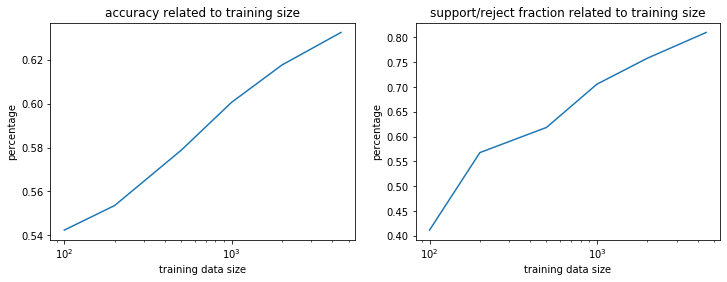

In [38]:
plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
plt.plot(list(expResultsAll.keys()),[x[0] for x in list(expResultsAll.values())])
plt.xscale("log")
plt.ylabel("percentage")
plt.xlabel("training data size")
plt.title("accuracy related to training size")

ax1 = plt.subplot(122)
plt.plot(list(expResultsAll.keys()),[x[1] for x in list(expResultsAll.values())])
plt.xscale("log")
plt.ylabel("percentage")
plt.xlabel("training data size")
plt.title("support/reject fraction related to training size")

plt.show()

## Classifying unlabeled tweets

In [39]:
import fasttext
import matplotlib
import os
import pandas as pd
import re

In [40]:
DATADIRECTORY = "/home/erikt/projects/puregome/data/text/"
LABELPREFIX = "__label__"
NEGATIVE = LABELPREFIX+"NEGATIVE"
POSITIVE = LABELPREFIX+"POSITIVE"
NEUTRAL = LABELPREFIX+"NEUTRAL"
IRRELEVANT = LABELPREFIX+"IRRELEVANT"
SUPPORTS = LABELPREFIX+"SUPPORTS"
REJECTS = LABELPREFIX+"REJECTS"
SUPPORT = ""
TEXT = "text"
USER = "user"
DIM = BESTDIM
EPOCH = BESTEPOCH
LR = BESTLR

In [41]:
def makeGrepCommandFromQuery(query):
    grepCommand = "grep"
    for orPart in query.split("|"):
        grepCommand += ' -e "'+orPart+'"'
    return(grepCommand)

def readData(datePattern,query):
    fileList = sorted(os.listdir(DATADIRECTORY))
    tmpFileName = "classify."+str(int(random.random()*LARGEINT))+".txt"
    testData = []
    for inFileName in fileList:
        if re.search(datePattern,inFileName):
            os.system("gunzip -c "+DATADIRECTORY+inFileName+" 2>/dev/null| head -1 >"+tmpFileName)
            os.system("gunzip -c "+DATADIRECTORY+inFileName+" 2>/dev/null| "+makeGrepCommandFromQuery(query)+" >> "+tmpFileName)
            try: df = pd.read_csv(tmpFileName)
            except: continue
            for i in range(0,len(df)):
                if re.search(query,df.iloc[i][TEXT],flags=re.IGNORECASE):
                    testData.append(df.iloc[i][USER]+" "+df.iloc[i][TEXT])
            os.unlink(tmpFileName)
    return(testData)
    
def classify(datePattern,query):
    testData = readData(datePattern,query)
    model = fasttext.train_supervised(FILEFASTTEXT,dim=DIM,epoch=EPOCH,lr=LR)
    predictedLabels = model.predict(testData)
    predictedGroups = pd.DataFrame(predictedLabels[0]).groupby(0).groups
    labelCountsPredicted = {label:len(predictedGroups[label]) for label in predictedGroups}
    nbrOfLabels = sum([labelCountsPredicted[label] for label in labelCountsPredicted if label != IRRELEVANT])
    labelPercentages = { label:round(100*labelCountsPredicted[label]/nbrOfLabels,1) for label in labelCountsPredicted}
    return(labelPercentages)

In [42]:
QUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
MAXDAYSPERMONTH = 31

results = {}
for month in "202002 202003 202004 202005 202006 202007".split():
    for day in range(1,MAXDAYSPERMONTH+1):
        date = month+str(day).zfill(2)
        try:
            labels = classify(date,QUERY)
            if not REJECTS in labels: labels[REJECTS] = 0
            if not SUPPORTS in labels: labels[SUPPORTS] = 0
            if not IRRELEVANT in labels: labels[IRRELEVANT] = 0
            if labels[REJECTS]+labels[SUPPORTS]+labels[IRRELEVANT] > 0:
                results[date] = labels
            print(date,labels[REJECTS],labels[SUPPORTS],labels[IRRELEVANT])
        except:
            print(date,"error")

20200201 6.7 93.3 240.0
20200202 14.0 86.0 304.7
20200203 3.2 96.8 138.7
20200204 4.7 95.3 125.6
20200205 8.3 91.7 164.6
20200206 41.0 59.0 223.1
20200207 6.7 93.3 257.8
20200208 7.8 92.2 205.9
20200209 22.4 77.6 181.6
20200210 9.3 90.7 109.3
20200211 7.1 92.9 673.8
20200212 5.0 95.0 190.0
20200213 9.3 90.7 292.6
20200214 10.7 89.3 216.1
20200215 10.8 89.2 337.8
20200216 4.1 95.9 210.2
20200217 9.3 90.7 209.3
20200218 14.3 85.7 160.3
20200219 11.8 88.2 432.4
20200220 9.3 90.7 886.0
20200221 18.2 81.8 539.4
20200222 24.4 75.6 275.6
20200223 4.1 95.9 191.8
20200224 11.5 88.5 394.2
20200225 39.1 60.9 182.6
20200226 20.8 79.2 232.5
20200227 3.3 96.7 137.7
20200228 14.6 85.4 117.5
20200229 17.5 82.5 222.8
20200230 error
20200231 error
20200301 18.4 81.6 156.3
20200302 5.4 94.6 111.8
20200303 3.6 96.4 101.2
20200304 12.5 87.5 253.6
20200305 10.0 90.0 272.9
20200306 7.9 92.1 172.4
20200307 7.4 92.6 135.8
20200308 4.0 96.0 87.1
20200309 6.0 94.0 71.6
20200310 3.7 96.3 75.9
20200311 6.5 93.5 59

## Visualization over time

In [43]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [44]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

In [46]:
DATEFORMAT = "%Y%m%d"
DAYSCOMBINED = 7

x = [datetime.datetime.strptime(k,DATEFORMAT) for k in results.keys()]
ySupports = movingAverage([results[k][SUPPORTS] for k in results.keys()],DAYSCOMBINED)
yRejects = movingAverage([results[k][REJECTS] for k in results.keys()],DAYSCOMBINED)
yIrrelevant = movingAverage([results[k][IRRELEVANT] for k in results.keys()],DAYSCOMBINED)

keyDates = []
for i in range(0,len(yIrrelevant)):
    if i < len(yIrrelevant)-1 and \
       (yIrrelevant[i] < 100 and yIrrelevant[i+1] >= 100 or yIrrelevant[i] >= 100 and yIrrelevant[i+1] < 100):
        keyDates.append(list(results.keys())[i])
        print(keyDates[-1])

20200312


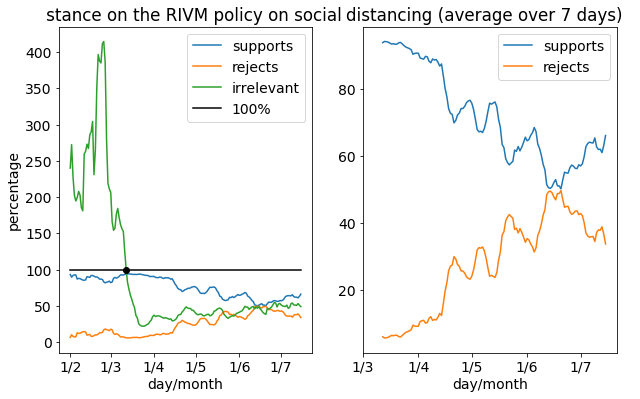

In [47]:
STARTDATE = keyDates[0]
ENDDATE = "20201231"

results = {k:results[k] for k in sorted(results.keys())}
font = {"size":14}
matplotlib.rc("font",**font)
plt.subplots(figsize=(10,6))

ax1 = plt.subplot(121)
plt.plot_date(x,ySupports,fmt="-",label="supports")
plt.plot_date(x,yRejects,fmt="-",label="rejects")
plt.plot_date(x,yIrrelevant,fmt="-",label="irrelevant")
plt.plot_date(x,[100 for i in x],fmt="-",label="100%",color="black")
for date in [STARTDATE]:
    plt.plot_date([datetime.datetime.strptime(date,DATEFORMAT)],[100],color="black")
plt.legend()
plt.ylabel("percentage")
plt.xlabel("day/month")
plt.title("   stance on the RIVM policy on "+"social")

dates = [d for d in results.keys()]
xPart = [x[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE]
ySupportsPart = [ySupports[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE] 
yRejectsPart = [yRejects[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE]
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))

ax2 = plt.subplot(122)
plt.plot_date(xPart,ySupportsPart,fmt="-",label="supports")
plt.plot_date(xPart,yRejectsPart,fmt="-",label="rejects")
plt.legend()
plt.xlabel("day/month")
plt.title("distancing (average over "+str(DAYSCOMBINED)+" days)  ")
plt.xticks([datetime.datetime.strptime(d,DATEFORMAT) for d in "20200301 20200401 20200501 20200601 20200701".split()])
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))

plt.show()

## Annotator comparison

In [50]:
annotators = []
annotatorData = {}
for i in range(0,len(annotations)):
    annotator = annotations.iloc[i][0]
    tweetId = annotations.iloc[i][2]
    tweetLabel = annotations.iloc[i][4]
    if not annotator in annotatorData: 
        annotatorData[annotator] = {}
        annotators.append(annotator)
    annotatorData[annotator][tweetId] = tweetLabel

In [60]:
total = 0
identical = 0
for tweetId in annotatorData[ANNOTATOR]:
    for annotator in annotators:
        if not annotator == ANNOTATOR and tweetId in annotatorData[annotator]:
            total += 1
            if annotatorData[annotator][tweetId] == annotatorData[ANNOTATOR][tweetId]: identical += 1
            else: 
                print(tweetId,annotatorData[ANNOTATOR][tweetId],annotatorData[annotator][tweetId])
                #print(tweets.loc[tweetId][TEXT])
print(total,identical)

1268107342220005377 SUPPORTS IRRELEVANT
1267584204696702980 SUPPORTS IRRELEVANT
1268229980351279117 SUPPORTS IRRELEVANT
1242710941961256960 SUPPORTS IRRELEVANT
1256556830374977537 SUPPORTS IRRELEVANT
1267535134213001216 IRRELEVANT REJECTS
1266518198637256707 REJECTS IRRELEVANT
1246404764524523520 SUPPORTS IRRELEVANT
1269586384546926593 REJECTS IRRELEVANT
1267524808931147776 SUPPORTS IRRELEVANT
1241616504124293122 REJECTS IRRELEVANT
1256175537841635333 SUPPORTS IRRELEVANT
1254430467471933445 SUPPORTS IRRELEVANT
1247498941983227904 SUPPORTS IRRELEVANT
1248537579579944960 IRRELEVANT SUPPORTS
1267702998811238400 REJECTS IRRELEVANT
1270803382391975945 SUPPORTS IRRELEVANT
1266632200453337090 SUPPORTS IRRELEVANT
1269328728045256705 IRRELEVANT REJECTS
1245075282391900166 SUPPORTS REJECTS
1241801334346723329 SUPPORTS IRRELEVANT
1266703642687606786 IRRELEVANT REJECTS
1266712890586943488 IRRELEVANT NEUTRAL
1274768593838891013 REJECTS IRRELEVANT
98 74
